In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import pandas as pd
import numpy as np
import datetime


# fact table
sessions_df = pd.read_json("data/sessions.jsonl", lines=True)

# dimension tables
deliveries_df = pd.read_json("data/deliveries.jsonl", lines=True)
products_df = pd.read_json("data/products.jsonl", lines=True)
users_df = pd.read_json("data/users.jsonl", lines=True)

In [2]:
MAKE_PLOTS = True
MAKE_PAIRPLOT = True
DATE_FORMAT = "%Y-%m-%dT%H:%M:%S"
PRICE_TRESHOLD = 100_000    # for outliers
WEIGHT_TRESHOLD = 50        # for outliers
NUM_OF_HOURS = 12
SEED = 42
SHOW_ALL_WARNINGS = False
SHOW_ONLY_ONE_WARNING = False

In [3]:
import warnings

if SHOW_ONLY_ONE_WARNING:
    warnings.filterwarnings(action='once')
elif not SHOW_ALL_WARNINGS:
    warnings.filterwarnings('ignore')

In [4]:
# 1.
deliveries_df["delivery_timestamp"] = deliveries_df["delivery_timestamp"].str.split('.', expand=True)[0]

# 2.
deliveries_df["purchase_timestamp"] = pd.to_datetime(deliveries_df["purchase_timestamp"], format=DATE_FORMAT)
deliveries_df["delivery_timestamp"] = pd.to_datetime(deliveries_df["delivery_timestamp"], format=DATE_FORMAT)

# 3.
deliveries_df["time_diff"] = deliveries_df["delivery_timestamp"] - deliveries_df["purchase_timestamp"]

# 4.
deliveries_df = deliveries_df[deliveries_df["time_diff"].notna()]

# 5.
# time diff as duration in seconds
deliveries_df["time_diff"] = deliveries_df["time_diff"].apply(datetime.timedelta.total_seconds)

# 6.
# deliveries_df = deliveries_df[deliveries_df["time_diff"] >= 0]

In [5]:
# drop rows where event_type is not equal "BUY_PRODUCT"
sessions_df = sessions_df[sessions_df["event_type"] == "BUY_PRODUCT"]
df = deliveries_df.merge(sessions_df, on="purchase_id", how="left")

In [6]:
# making sure, that timestamp == purchase_timestamp
num_of_rows_before = df.shape[0]
df = df[df["timestamp"] == df["purchase_timestamp"]]
num_of_rows_after = df.shape[0]

assert(num_of_rows_before == num_of_rows_after)

# now we can drop timestamp column, as it is redundant
df = df.drop(columns="timestamp")

In [7]:
df = df.merge(users_df, on="user_id", how="left")
df = df.merge(products_df, on="product_id", how="left")

In [8]:
# rejecting outliers for given PRICE_TRESHOLD
df = df[df["price"] <= PRICE_TRESHOLD]

# rejecting outliers for given WEIGHT_TRESHOLD
df = df[df["weight_kg"] <= WEIGHT_TRESHOLD]

In [9]:
# deleting rows with prices below 0
df = df[df["price"] >= 0]

In [10]:
df_with_time_diff_below_0 = df
df = df[df["time_diff"] >= 0]

In [11]:
df['day_of_week'] = df['purchase_timestamp'].dt.dayofweek

In [12]:
df['city_and_street'] = df['city'] + ' ' + df['street']
display(df[['city_and_street', 'city', 'street']])

,city_and_street,city,street
0,Poznań plac Dębowa 11/53,Poznań,plac Dębowa 11/53
1,Poznań plac Dębowa 11/53,Poznań,plac Dębowa 11/53
2,Poznań plac Dębowa 11/53,Poznań,plac Dębowa 11/53
3,Poznań plac Dębowa 11/53,Poznań,plac Dębowa 11/53
4,Poznań plac Dębowa 11/53,Poznań,plac Dębowa 11/53
...,...,...,...
11447,Poznań ul. Zachodnia 88,Poznań,ul. Zachodnia 88
11448,Poznań ul. Zachodnia 88,Poznań,ul. Zachodnia 88
11449,Poznań ul. Zachodnia 88,Poznań,ul. Zachodnia 88
11450,Poznań ul. Zachodnia 88,Poznań,ul. Zachodnia 88


In [13]:

df['purchase_datetime_delta'] = (df['purchase_timestamp'] - df['purchase_timestamp'].min())  / np.timedelta64(1,'D')

In [14]:
# drop columns
ADDITIONAL_COLUMNS_TO_DROP = ["delivery_timestamp",
                              "session_id",
                              "purchase_id",
                              "event_type",
                              "name",
                              "city_and_street",
                              "brand",
                              "user_id",
                              'product_name',
                              'offered_discount']
df = df.drop(columns=ADDITIONAL_COLUMNS_TO_DROP)
df = df.drop(columns="optional_attributes") # chyba do zmiany - wysokosc itp.
df = df.drop(columns="purchase_timestamp") # na pewno do zmiany

In [15]:
def one_hot_encode_a_col_in_pd(df, col_name):
    one_hot = pd.get_dummies(df[col_name], drop_first=True)
    df = df.drop(columns=col_name)
    df = df.join(one_hot)
    return df

In [16]:
COLUMNS_TO_ONE_HOT = ["delivery_company", "city", "category_path", "street", 'day_of_week', 'product_id']

for col_name in COLUMNS_TO_ONE_HOT:
    df = one_hot_encode_a_col_in_pd(df, col_name)

In [17]:
df = df.dropna()
print(df.shape)
# one-hot encoding took care of missing data, so shape has not changed

(11315, 595)


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11315 entries, 0 to 11451
Columns: 595 entries, time_diff to 1653
dtypes: float64(4), uint8(591)
memory usage: 7.1 MB


In [19]:
# specify columns for standardization scaling (Z-score normalization)
cols_to_std = []

# specify columns for min-max scaling
# offered_discount, price, weight_kg, purchase_datetime_delta
cols_to_min_max = ['price', 'weight_kg', 'purchase_datetime_delta']
# cols_to_min_max = ['weight_kg']

In [20]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

for col in cols_to_std:
    x = df[col].values
    std_scaler = StandardScaler()
    x_scaled = std_scaler.fit_transform(x.reshape(-1, 1))
    df[col] = x_scaled

for col in cols_to_min_max:
    x = df[col].values
    min_max_scaler = MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x.reshape(-1, 1))
    df[col] = x_scaled

In [21]:
df.head()

,time_diff,price,weight_kg,purchase_datetime_delta,516,620,Kraków,Poznań,Radom,Szczecin,...,1627,1628,1629,1630,1631,1632,1633,1634,1635,1653
0,194397.0,0.228930,0.020000,0.459215,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,184285.0,0.406238,0.000800,0.191245,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,164705.0,0.665416,0.000000,0.082285,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,252885.0,0.448400,0.010667,0.822722,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,228672.0,0.032173,0.008667,0.343154,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def split_data(df, target_column="time_diff"):
    y = df["time_diff"].to_numpy()
    X = df.drop(columns="time_diff")
    return train_test_split(X, y, test_size=0.2, random_state=SEED)

In [23]:
def train_models(models_list, X_train, y_train):
    for model in models_list:
        model.fit(X_train, y_train)
    return models_list

In [24]:
def create_df_with_predictions(models_list, X_test, y_test):
    y_pred_df = pd.DataFrame()
    y_pred_df["y_test"] = y_test
    for model in models_list:
        y_pred_df[f"{type(model).__name__} prediction"] = model.predict(X_test)
    return y_pred_df

In [25]:
def display_predictions(y_pred_df):
    display(y_pred_df.head())
    display(y_pred_df.info())
    display(y_pred_df.describe())

In [26]:
def print_scores(models_list, X_test, y_test):
    for model in models_list:
        score = model.score(X_test, y_test)
        print(f"{type(model).__name__} score = {score}")

In [27]:
def print_percent_of_good_predictions(models_list, X_test, y_test, error=NUM_OF_HOURS*60*60):
    for model in models_list:
        predictions = model.predict(X_test)
        predictions_time_diff = np.abs(y_test - predictions)
        num_of_good_predictions = (predictions_time_diff < error).sum()
        percent_of_good_predictions = num_of_good_predictions / len(predictions_time_diff)
        print(f'number of good predictions for {type(model).__name__} = {num_of_good_predictions}')
        print(f'which is {percent_of_good_predictions * 100}%')

In [28]:
# from sklearn.linear_model import LinearRegression, Ridge, Lasso
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor


# X_train, X_test, y_train, y_test = split_data(df)

# models_list = [Ridge(alpha=0.1),
#                Lasso(alpha=0.1),
#                DecisionTreeRegressor(random_state=SEED),
#                RandomForestRegressor(random_state=SEED)]
# models_list = train_models(models_list, X_train, y_train)

# y_pred_df = create_df_with_predictions(models_list, X_test, y_test)
# # display_predictions(y_pred_df)

# print_scores(models_list, X_test, y_test)

# print_percent_of_good_predictions(models_list, X_test, y_test)

# keras test

In [29]:
X_train, X_test, y_train, y_test = split_data(df)
input_shape = X_train.shape[1]

Epoch 1/500
36/36 [==============================] - 2s 34ms/step - loss: 233531.7969 - mae: 233531.7969 - val_loss: 231076.8906 - val_mae: 231076.8906
Epoch 2/500
36/36 [==============================] - 1s 23ms/step - loss: 233530.0312 - mae: 233530.0312 - val_loss: 231075.3438 - val_mae: 231075.3438
Epoch 3/500
36/36 [==============================] - 1s 26ms/step - loss: 233526.2500 - mae: 233526.2500 - val_loss: 231072.0625 - val_mae: 231072.0625
Epoch 4/500
36/36 [==============================] - 1s 25ms/step - loss: 233519.1094 - mae: 233519.1094 - val_loss: 231066.0312 - val_mae: 231066.0312
Epoch 5/500
36/36 [==============================] - 1s 25ms/step - loss: 233508.3281 - mae: 233508.3281 - val_loss: 231056.9531 - val_mae: 231056.9531
Epoch 6/500
36/36 [==============================] - 1s 25ms/step - loss: 233493.5000 - mae: 233493.5000 - val_loss: 231044.6562 - val_mae: 231044.6562
Epoch 7/500
36/36 [==============================] - 1s 24ms/step - loss: 233475.0156 - 

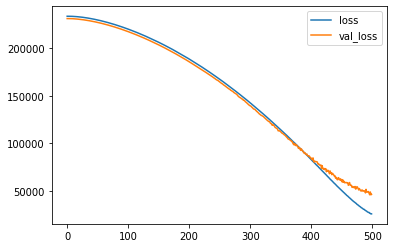

In [30]:
from tensorflow import keras
from tensorflow.keras import layers, callbacks


early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model = keras.Sequential([
    layers.BatchNormalization(input_shape=[input_shape]),

    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(1),
])
model.compile(
    optimizer='adam',
    loss='mae',
    metrics=['r_square']
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=256,
    epochs=500,
    callbacks=[early_stopping], # put your callbacks in a list
    # verbose=0,  # turn off training log
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

In [32]:
print_percent_of_good_predictions([model], X_test, y_test)

71/71 [==============================] - 0s 2ms/step
number of good predictions for Sequential = 1682347
which is 74341.44940344675%


In [35]:
error = NUM_OF_HOURS * 60 * 60
predictions = model.predict(X_test)
predictions_time_diff = np.abs(y_test - predictions)
num_of_good_predictions = (predictions_time_diff < error).sum()
percent_of_good_predictions = num_of_good_predictions / len(predictions_time_diff)
print(f'number of good predictions for {type(model).__name__} = {num_of_good_predictions}')
print(f'which is {percent_of_good_predictions * 100}%')

71/71 [==============================] - 0s 3ms/step
number of good predictions for Sequential = 1682347
which is 74341.44940344675%


In [41]:
display(predictions_time_diff)

array([[  6952.125   ,  47992.875   ,  23022.875   , ...,  43279.875   ,
         43313.875   ,  58036.125   ],
       [ 51245.109375,   3699.890625,  21270.109375, ...,   1013.109375,
           979.109375, 102329.109375],
       [ 29746.53125 ,  25198.46875 ,    228.46875 , ...,  20485.46875 ,
         20519.46875 ,  80830.53125 ],
       ...,
       [ 71209.609375,  16264.609375,  41234.609375, ...,  20977.609375,
         20943.609375, 122293.609375],
       [ 52511.1875  , 107456.1875  ,  82486.1875  , ..., 102743.1875  ,
        102777.1875  ,   1427.1875  ],
       [   946.15625 ,  55891.15625 ,  30921.15625 , ...,  51178.15625 ,
         51212.15625 ,  50137.84375 ]])

In [42]:
display(predictions_time_diff.shape)

(2263, 2263)

In [38]:
display(X_test)

,price,weight_kg,purchase_datetime_delta,516,620,Kraków,Poznań,Radom,Szczecin,Warszawa,...,1627,1628,1629,1630,1631,1632,1633,1634,1635,1653
10825,0.013589,0.000467,0.660933,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3593,0.027859,0.001333,0.558801,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5653,0.119751,0.013733,0.913933,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4854,0.124076,0.226667,0.659243,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3864,0.134886,0.023667,0.498738,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6667,0.032173,0.008667,0.177023,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
721,0.632184,0.680000,0.563015,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8928,0.836941,0.001733,0.762100,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8521,0.092714,0.166667,0.213929,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
y_pred_df = create_df_with_predictions([model], X_test, y_test)
display_predictions(y_pred_df)

71/71 [==============================] - 0s 3ms/step


,y_test,Sequential prediction
0,225013.0,218060.875000
1,170068.0,173767.890625
2,195038.0,195266.468750
3,279415.0,205839.546875
4,331221.0,260865.640625


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2263 entries, 0 to 2262
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   y_test                 2263 non-null   float64
 1   Sequential prediction  2263 non-null   float32
dtypes: float32(1), float64(1)
memory usage: 26.6 KB


None

,y_test,Sequential prediction
count,2263.000000,2263.000000
mean,231077.817941,199851.406250
std,79705.119199,59679.675781
min,33091.000000,6380.562012
25%,174344.000000,151710.859375
50%,222482.000000,200075.703125
75%,281067.000000,245646.937500
max,535390.000000,354304.312500
